**Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
from time import time 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [75]:
class LinearRegression():
    
    def __init__(self, size=100, order = 10, a=0.05, b = 0.1):
        # Train Test Validation Sets and their labels 
        self.X, self.X_test, self.y, self.y_test, self.X_val, self.y_val  = [], [], [], [], [], []
        self.W = []  # unknown parameters
        self.order  = order 
        self.size = size 
        self.X_max = 10  # X ~ U[0,10]
        self.a = a
        self.b= b
        
        self.generate_data()
    
    def generate_data(self):
        
        self.X = np.random.uniform(0.0001, 10., self.size) # uniformly distributed X ~ U[0,1]   
        self.X = np.array( sorted( self.X ))
        self.y = self.a * self.X + self.b + np.random.standard_normal(self.size) # y = a*x + b + epsilon
        self.y = self.y.reshape(-1,1)
        
        self.X = self.X/max(self.X)  # To avoid OVER-FLOW error during gradient-descent 
        
        self.X = np.array([self.X**i for i in range(0,self.order+1)]).T # generate nth order polynomial features 
        
        
        # 60% training & 40% testing dataset 
        indexes = np.arange(len(self.X))
        np.random.shuffle(indexes)
        
        test_sz = int(0.4*len(self.X))
        
        x_test_indexes = sorted(indexes[-test_sz:])
        x_train_indexes = sorted(indexes[:-test_sz])
        
        self.X_test = self.X[x_test_indexes,:]
        self.y_test = self.y[x_test_indexes,:]
                                  
        self.X = self.X[x_train_indexes, : ]
        self.y = self.y[x_train_indexes, : ]
        
        
    
    def loss_without_regularization(self):
        Jw = (1/2)*((self.X@self.W - self.y).T)@(self.X@self.W - self.y)
        Jw = Jw.reshape(1)[0]
        return Jw
    
    def grad_without_reg(self):
        grad = self.X.T@(self.X@self.W - self.y)
        return grad 
    
    # alpha by exact line search if NO regularization  
    def exact_line_search_alpha(self):
        grad_ = self.grad_without_reg()
        alpha = np.linalg.norm(grad_)**2/ (  grad_.T@(self.X.T@self.X )@grad_ )
        alpha = alpha[0]
        return alpha
    
    def loss_ridge_reg(self, lambda_):
        Jw = self.loss_without_regularization() + lambda_*(np.linalg.norm(self.W)**2)
        return Jw
    
    
    def grad_ridge_reg(self,lambda_):
        grad = self.grad_without_reg() + 2*lambda_*self.W
        return grad 
    
    # alpha  by exact line search for ridge reg. 
    def exact_line_search_alpha_ridge(self, lambda_):
        grad_ridge = self.grad_ridge_reg(lambda_)
        alpha = np.linalg.norm(grad_ridge)**2/ (  grad_ridge.T@(self.X.T@self.X + lambda_*np.eye(len(self.X[0])))@grad_ridge )
        alpha = alpha[0]
        return alpha
    
    
    def loss_lasso_reg(self, lambda_):
        Jw = self.loss_without_regularization() + lambda_*np.sum( np.abs(self.W))
        return Jw
    
    def grad_lasso_reg(self,lambda_):
        grad = self.grad_without_reg() + lambda_*(np.sign(self.W).reshape(-1,1))
        return grad 

    def loss_elastic_net_reg(self, lambda_1, lambda_2): 
        Jw = self.loss_without_regularization() +  lambda_1*(np.linalg.norm(self.W)**2) + lambda_2*np.sum( np.abs(self.W))
        return Jw 

    def grad_elastic_net_reg(self,lambda_1, lambda_2):
        grad = self.grad_without_reg() + 2*lambda_1*self.W + lambda_2*(np.sign(self.W).reshape(-1,1))
        return grad 

    def out_of_sample_performance(self):
        self.y_pred = self.X_test@self.W
        loss = (1/2)*np.sum( (self.y_pred - self.y_test)**2 ) 
        return loss 
    
    def in_sample_performance(self):
        self.y_pred = self.X@self.W
        loss = (1/2)*np.sum( (self.y_pred - self.y)**2 ) 
        return loss 
    
    def val_set_performance(self):
        y_pred = self.X_val@self.W
        loss = (1/2)*np.sum(( y_pred - self.y_val)**2 ) 
        return loss 
    
    def plot_fitted_model(self, X, y):
        y_pred = X@self.W
        plt.scatter(X[:,1]*10,y,alpha=0.2)
        plt.plot(X[:,1]*10,y_pred)
        plt.show()
        
    # Find coefficients of desired polynomial using gradient descent & regularization
    def PolyReg_GD(self, max_iter=100000, regularization_method = None, lambda_lasso = 1e-3 , lambda_ridge= 1e-3, lambdas_elastic = [1e-3, 1e-3], show_results=True):
        
        error_threshold = 7e-2
        lr = 0.006 # learning rate 
        iteration_cntr = 0 
                
        # randomly initialize self.W 
        self.W = 5*np.random.rand(self.X.shape[1]).reshape(-1,1)
        
        loss_prev = 1e+10  # Assume some high initial loss 
        
        while iteration_cntr < max_iter : 
            
            iteration_cntr += 1 
                        
            if regularization_method == None : 
                loss = self.loss_without_regularization() 
                grad = self.grad_without_reg()
                lr = self.exact_line_search_alpha()
            
            elif regularization_method == 'ridge' : 
                loss = self.loss_ridge_reg(lambda_ridge) 
                grad = self.grad_ridge_reg(lambda_ridge)
                lr = self.exact_line_search_alpha_ridge(lambda_ridge)
            
            elif regularization_method == 'lasso' : 
                loss = self.loss_lasso_reg(lambda_lasso) 
                grad = self.grad_lasso_reg(lambda_lasso)
            
            elif regularization_method == 'elastic_net' : 
                loss = self.loss_elastic_net_reg(*lambdas_elastic) 
                grad = self.grad_elastic_net_reg(*lambdas_elastic)
            
            # Exit condition 1 : If previous loss is less than current loss --> we have crossed minima so break the loop 
            if (loss_prev < loss) :
                if show_results : 
                    print("Breaking at iteration : ", iteration_cntr)
                break 
            
            # Exit condition 2 : loss become significantly small                        
            if loss < error_threshold : 
                if show_results : 
                    print("Loss : ", loss, "Iteration : ", iteration_cntr )
                    print("Loss is now below required threshold !! Breaking out of loop ")
                break
            
            # Exit condition 3 :( Corresponding to exact line search in case of without regularization and ridge regularization)
            if (loss_prev - loss) < 1e-3 : 
                if show_results : 
                    print("Minimum Loss using exact line search : ",loss)
                    print("Breaking out of loop . Bye !!", "Iteration : ",iteration_cntr)
                break
                
            loss_prev = loss 
            
            # Update W 
            self.W = self.W - lr*grad 
            
            
        #  In case if algorithm fail to converge loops ends 
        if iteration_cntr == max_iter : 
            if show_results : 
                print("Loss : ", loss)
                print("No of iterations exceeds %d"%iteration_cntr)
            
        



**Part 1**

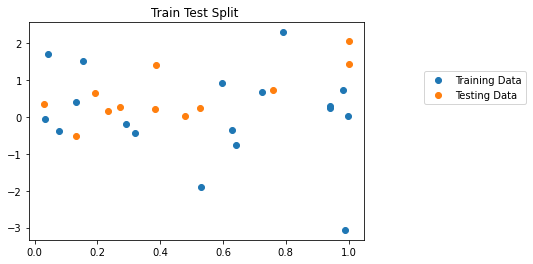

In [76]:
# Lets check if above class we written works properly 
lr_model = LinearRegression(size=30,order=10)  # size = 30, order of polynomial as 10 
plt.title('Train Test Split ')
plt.scatter(lr_model.X[:,1],lr_model.y, label='Training Data')
plt.scatter(lr_model.X_test[:,1],lr_model.y_test, label='Testing Data')
plt.legend(bbox_to_anchor=(1.5,0.8))
plt.show()

Minimum Loss using exact line search :  10.34411275825391
Breaking out of loop . Bye !! Iteration :  98
in sample loss :  10.344112758253912
out of sample loss : 3.1513045488534095


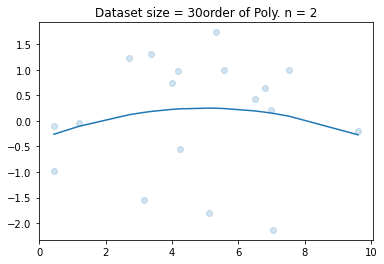

Minimum Loss using exact line search :  6.269151308997632
Breaking out of loop . Bye !! Iteration :  182
in sample loss :  6.269151308997631
out of sample loss : 7.943648085432183


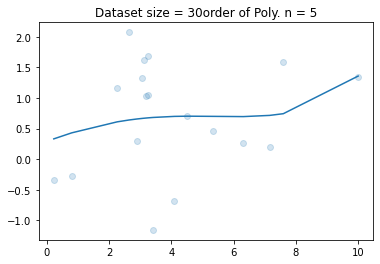

Minimum Loss using exact line search :  11.01208815635106
Breaking out of loop . Bye !! Iteration :  74
in sample loss :  11.012088156351062
out of sample loss : 8.387870249639715


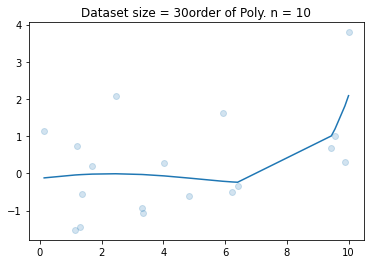

Minimum Loss using exact line search :  12.803699237696447
Breaking out of loop . Bye !! Iteration :  4
in sample loss :  12.80369923769645
out of sample loss : 12.503981415609232


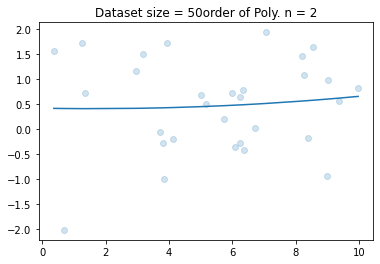

Minimum Loss using exact line search :  11.365415241331267
Breaking out of loop . Bye !! Iteration :  138
in sample loss :  11.365415241331268
out of sample loss : 10.22980747391666


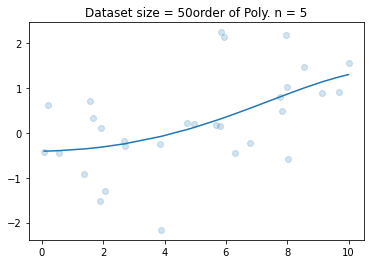

Minimum Loss using exact line search :  11.89544201145176
Breaking out of loop . Bye !! Iteration :  106
in sample loss :  11.89544201145176
out of sample loss : 7.133157750882856


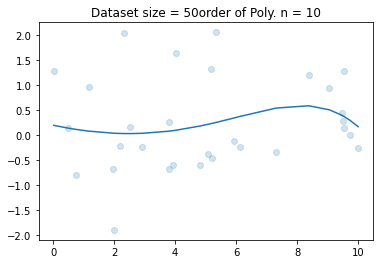

In [77]:
# Polynomial Regression fit change with data size and order of polynomial 
sizes = [30,50]  # You can try out different data sizes . Here I have used 60% data for training and 40% for testing 
orders = [2,5,10]
for s in sizes : 
    for o in orders : 
        lr_model = LinearRegression(size=s,order=o)
        lr_model.PolyReg_GD()
        print("in sample loss : ", lr_model.in_sample_performance())
        print("out of sample loss :", lr_model.out_of_sample_performance())
        plt.title("Dataset size = %d"%s +  "order of Poly. n = %d"%o)
        lr_model.plot_fitted_model(lr_model.X, lr_model.y)


**Variation of Errors with Dataset sizes for each order**

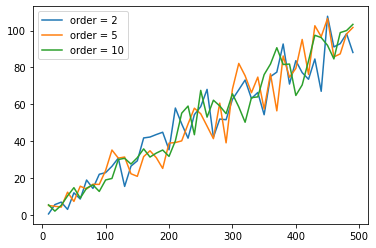

In [82]:
sizes = np.arange(10,500,10)
orders = [2,5,10]
errors = np.zeros((len(sizes),len(orders)))
for i,s in enumerate(sizes) : 
    for j,o in enumerate(orders) : 
        lr_model = LinearRegression(size=s,order=o)
        lr_model.PolyReg_GD(show_results=False)
        errors[i,j] = lr_model.out_of_sample_performance()
for j in range(len(orders)): 
    plt.plot(sizes,errors[:,j], label='order = '+str(orders[j]))
plt.legend()
plt.show()

**Part 2**

**Dataset Size = 30**

**Polynomial Order = 10**

In [13]:
order = 10
size = 30

**Variation of Coefficients with respect to regularization constant**

In [20]:
def draw_graph_of_variation_of_reg_const(regularization_method='ridge'):
    Coeffs = []
    size = 30
    order = 10 
    lambdas = np.array([10**i for i in range(-5,3)])
    for lambda_ in lambdas : 
        lr_model = LinearRegression(size=size,order=order)
        if regularization_method == 'ridge' : 
            lr_model.PolyReg_GD(regularization_method=regularization_method,lambda_ridge=lambda_,show_results=False)
        elif regularization_method == 'lasso' : 
            lr_model.PolyReg_GD(regularization_method=regularization_method,lambda_lasso=lambda_,show_results=False)
        elif regularization_method == 'elastic_net' : 
            lr_model.PolyReg_GD(regularization_method=regularization_method,lambdas_elastic=lambda_,show_results=False)
        
        Coeffs.append(lr_model.W.reshape(-1))
    Coeffs = np.array(Coeffs)

    plt.figure(figsize=(20,10))
    plt.title('Variation of Coefficients with regularization constant in '+ regularization_method+ ' regression')
    for idx in range(Coeffs.shape[1]):
        x,y = np.log10(lambdas), Coeffs[:, idx]
        plt.plot(x,y,label='W_'+str(idx))
    plt.legend(loc='upper right')
    plt.show()

**Ridge Regression**

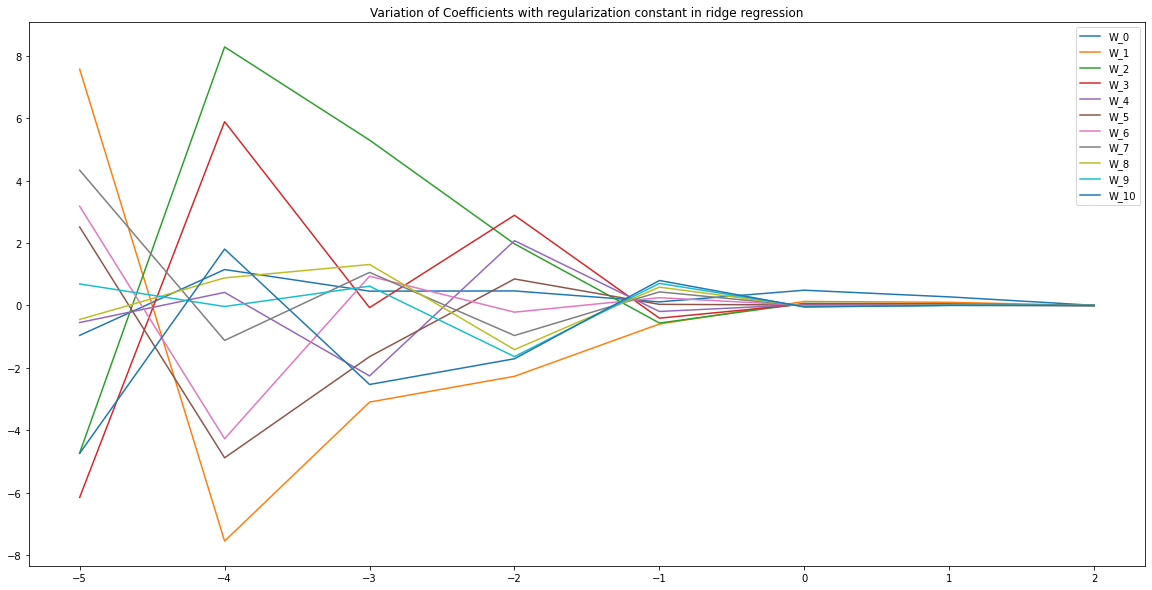

In [21]:
draw_graph_of_variation_of_reg_const('ridge')

**Lasso regularization**

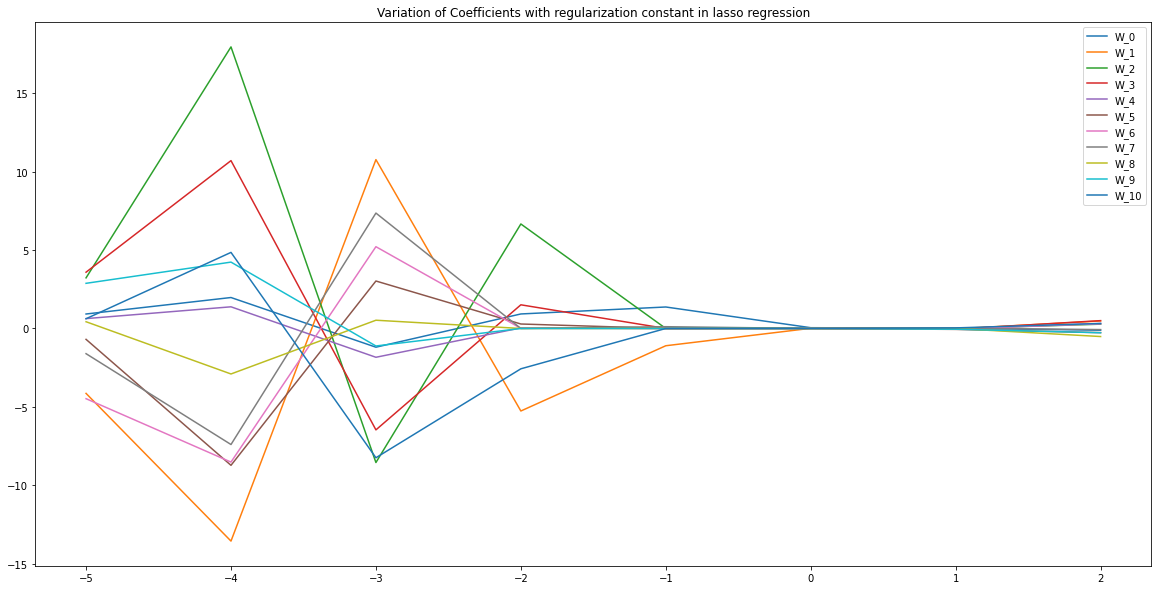

In [22]:
draw_graph_of_variation_of_reg_const('lasso')

**Fixing Regularization Constant Using Six Fold Validation Approach**

In [45]:
def K_fold_validation_regularization(max_iter=10000, K = 6, reg_method='ridge', lambdas = []):
    losses_data = []
    
    size = 30
    order = 10
    
    for _ in range(5):
        print(_)
        
        # Given 60% training --> 6-fold cross validation  

        lr_model = LinearRegression(size=size,order=order)

        # Make a copy of original train dataset so we can retreive original data during cross-validation at every fold 
        X_train = lr_model.X.copy()
        y_train = lr_model.y.copy()


        losses_lambdas = []

        for lambda_ in lambdas : 
            
            losses_fold = []
            
            for fold in range(6):

                lr_model.X = X_train.copy()
                lr_model.y = y_train.copy()

                val_sz = int(len(lr_model.X)*(1/6))


                indexes = list(np.arange(len(lr_model.X)).reshape(-1))
                x_indx_val = indexes[ fold*val_sz : (fold+1)*val_sz]
                del indexes[fold*val_sz : (fold+1)*val_sz]
                x_train_indexes = indexes 


                lr_model.X_val = lr_model.X[  fold*val_sz : (fold+1)*val_sz, : ]
                lr_model.y_val = lr_model.y[  fold*val_sz : (fold+1)*val_sz , : ]


                lr_model.X = lr_model.X[x_train_indexes,:]
                lr_model.y = lr_model.y[x_train_indexes,:]

                # Train the model 
                
                if reg_method == 'ridge':
                    lr_model.PolyReg_GD(max_iter=max_iter, regularization_method=reg_method , lambda_ridge=lambda_[0], show_results=False)
                elif reg_method == 'lasso':
                    lr_model.PolyReg_GD(max_iter=max_iter, regularization_method=reg_method , lambda_lasso=lambda_[0], show_results=False)
                elif reg_method == 'elastic_net': 
                    lr_model.PolyReg_GD(max_iter=max_iter, regularization_method=reg_method , lambdas_elastic=lambda_, show_results=False)

                loss = lr_model.val_set_performance()

                losses_fold.append(loss)

            losses_lambdas.append(np.mean(losses_fold))
        losses_data.append(losses_lambdas)
    losses_data = np.array(losses_data)
    losses_data = np.mean(losses_data,axis=0)
    return losses_data 



def best_lambda(lambdas, avg_loss_lambdas):
    min_loss = avg_loss_lambdas[0]
    lambda_selected = lambdas[0]

    for idx, lambda_ in enumerate(lambdas) :
        if avg_loss_lambdas[idx] < min_loss : 
            lambda_selected = lambda_
            min_loss = avg_loss_lambdas[idx]

    return lambda_selected


**Ridge Regularization**

In [54]:
max_iter = 100000  # Max number of iterations to run 

In [26]:
lambdas = np.array([[10**i] for i in range(-5,3)])
avg_loss_lambdas_ridge = K_fold_validation_regularization(max_iter=max_iter, reg_method='ridge',lambdas=lambdas)

0
1
2
3
4


In [27]:
lambdas = np.array([[10**i] for i in range(-5,3)])
best_lambda_ridge = best_lambda(lambdas, avg_loss_lambdas_ridge)
print("Best Lambda for ridge regularization : ", *best_lambda_ridge)

Best Lambda for ridge regularization :  10.0


Loss :  5.422785217730603
No of iterations exceeds 100000
in sample loss :  3.9870631152671496
out of sample loss : 3.2929784734437


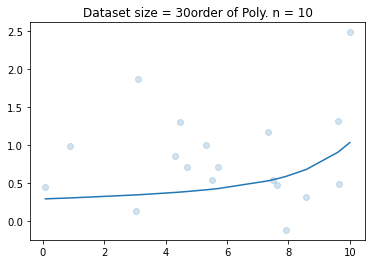

In [33]:
# See plot of fitted curve on best_lambda 
s = 30
o = 10 
lr_model = LinearRegression(size=s,order=o)
lr_model.PolyReg_GD(max_iter=max_iter, regularization_method='ridge',lambda_ridge = best_lambda_ridge[0])
print("in sample loss : ", lr_model.in_sample_performance())
print("out of sample loss :", lr_model.out_of_sample_performance())
plt.title("Dataset size = %d"%s +  "order of Poly. n = %d"%o)
lr_model.plot_fitted_model(lr_model.X, lr_model.y)

**Lasso Regularization**

In [55]:
lambdas = np.array([[10**i] for i in range(-5,3)])
avg_loss_lambdas_lasso = K_fold_validation_regularization(max_iter=max_iter, reg_method='lasso',lambdas=lambdas)

0
1
2
3
4


In [56]:
lambdas = np.array([[10**i] for i in range(-5,3)])
best_lambda_lasso = best_lambda(lambdas, avg_loss_lambdas_lasso)
print("Best Lambda for lasso regularization : ", *best_lambda_lasso)

Best Lambda for ridge regularization :  1.0


Loss :  4.460934661377645
No of iterations exceeds 100000
in sample loss :  3.080890448882318
out of sample loss : 4.058389632737611


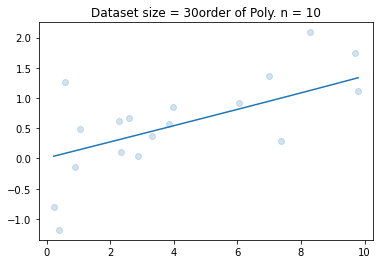

In [57]:
# See plot of fitted curve on best_lambda 
s = 30
o = 10 
lr_model = LinearRegression(size=s,order=o)
lr_model.PolyReg_GD(max_iter=max_iter, regularization_method='lasso',lambda_lasso = best_lambda_lasso[0])
print("in sample loss : ", lr_model.in_sample_performance())
print("out of sample loss :", lr_model.out_of_sample_performance())
plt.title("Dataset size = %d"%s +  "order of Poly. n = %d"%o)
lr_model.plot_fitted_model(lr_model.X, lr_model.y)

**Elastic Net Regularization**

In [60]:
max_iter = 10000 
lambdas = np.array( [ [10**i, 10**j] for i in range(-5,3) for j in range(-5,3)])
avg_loss_lambdas_elastic = K_fold_validation_regularization(max_iter=max_iter,reg_method='elastic_net', lambdas=lambdas)

0
1
2
3
4


In [61]:
lambdas = np.array( [ [10**i, 10**j] for i in range(-5,3) for j in range(-5,3)])
best_lambda_elastic = best_lambda(lambdas, avg_loss_lambdas_elastic)
print("Best Lambdas for elastic net  regularization : ", *best_lambda_elastic)

Best Lambdas for elastic net  regularization :  0.1 1.0


Loss :  5.958113048207823
No of iterations exceeds 10000
in sample loss :  4.596408307516006
out of sample loss : 9.455291003049082


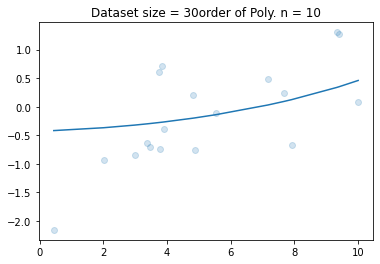

In [63]:
# See plot of fitted curve on best_lambda 
s = 30
o = 10 
lr_model = LinearRegression(size=s,order=o)
lr_model.PolyReg_GD(max_iter=max_iter, regularization_method='elastic_net',lambdas_elastic = best_lambda_elastic)
print("in sample loss : ", lr_model.in_sample_performance())
print("out of sample loss :", lr_model.out_of_sample_performance())
plt.title("Dataset size = %d"%s +  "order of Poly. n = %d"%o)
lr_model.plot_fitted_model(lr_model.X, lr_model.y)

--- 